# 0. Imports

In [1]:
%cd ../../..

/workspace/pixel-art-character-generation


In [2]:
from sampling.conditional_probability_path import GaussianConditionalProbabilityPath
from sampling.sampleable import PixelArtSampler
from sampling.noise_scheduling import LinearAlpha, LinearBeta
from models.unet import PixelArtUNet
from training.trainer import UnguidedTrainer
from training.evaluation import FID
from training.ema import EMA
from diff_eq.ode_sde import UnguidedVectorFieldODE
from diff_eq.simulator import EulerSimulator
from utils.visualization import visualize_training_logs
from utils.helpers import tensor_to_rgba_image

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Train

In [4]:
if 'unet' in locals():
    del unet
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Initialize probability path
sampler = PixelArtSampler('dataset/images').to(device)
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=[4, 128, 128],
    alpha=LinearAlpha(),
    beta=LinearBeta()
).to(device)

# Initialize model
unet = PixelArtUNet(
    channels=[128, 256, 512, 512],
    num_residual_layers=2,
    t_embed_dim=128,
    midcoder_dropout_p=0.2
).to(device)

# Initialize evaluation metric
metric = FID(
    feature=2048,
    normalize=True,
    image_size=(299, 299)
)

# Initialize EMA
ema = EMA(model=unet, max_decay=0.999)

# Initialize trainer
trainer = UnguidedTrainer(
    path=path,
    model=unet,
    experiment_dir="training/experiments/unet_mid_ema",
    eval_metric=metric,
    ema=ema
)

# Train :D
trainer.train(
    device=device,
    num_epochs=20000,
    batch_size=64,
    lr=1e-4,
    weight_decay=5e-4,
    validate_every=250,
    val_timesteps=200,
    resume=False,
    lr_warmup_steps_frac=0.1,
    num_images_to_save=3,
    save_images_every=250
)

Model size: 163.1216 MiB


100%|██████████| 20000/20000 [6:30:31<00:00,  1.17s/it, train_loss=0.0296, val_metric=157.5650, best_val_metric=135.8267 (epoch 12749)]   


# 2. Visualize model performance over time

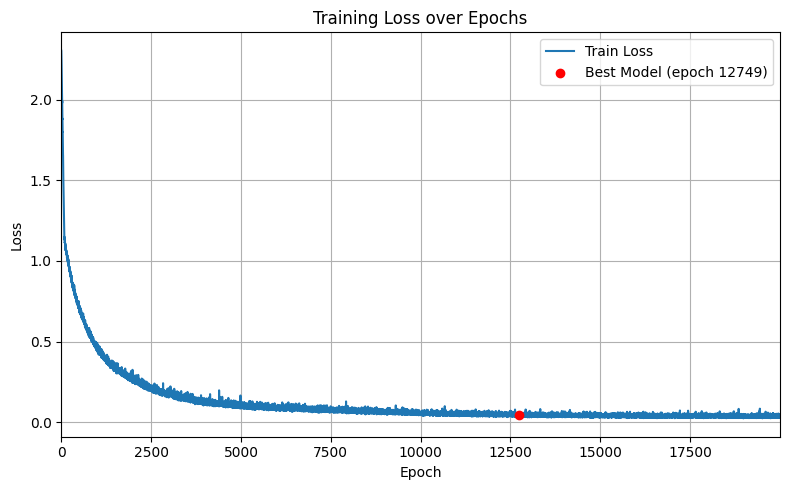

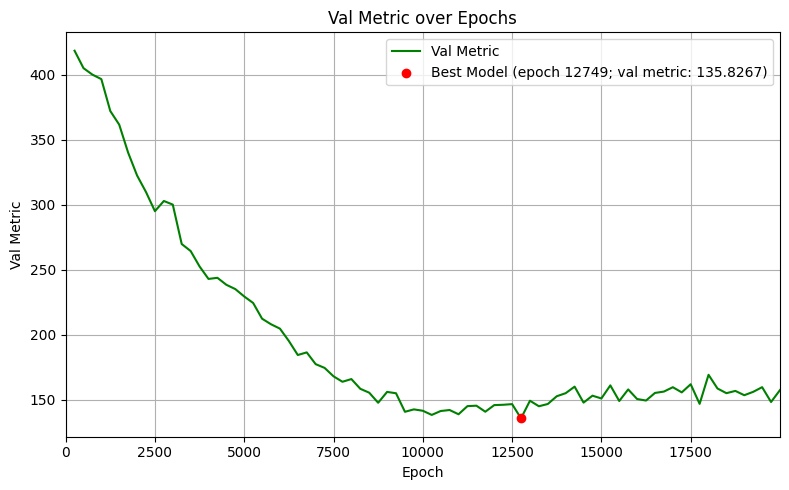

In [5]:
visualize_training_logs(log_path="training/experiments/unet_mid_ema/training_log.csv", scale="linear")

# 3. Evaluate on the test set

In [6]:
# Dataset sampler
sampler = PixelArtSampler('dataset/images').to(device)

# Initialize model
model = PixelArtUNet(
    channels=[128, 256, 512, 512],
    num_residual_layers=2,
    t_embed_dim=128,
    midcoder_dropout_p=0.2
).to(device)

# --- Load checkpoint with EMA ---
checkpoint_path = "training/experiments/unet_mid_ema/best_model.pt"
cp = torch.load(checkpoint_path, map_location=device)

ema2 = EMA(model)
ema2.load_state_dict(cp["ema_state"])
ema2.apply_shadow()   # swap in EMA weights
model.eval()

# Path
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=[4, 128, 128],
    alpha=LinearAlpha(),
    beta=LinearBeta()
).to(device)
path.eval()

# Evaluation metric
metric = FID(
    feature=2048,
    normalize=True,
    image_size=(299, 299)
)

# Trainer
trainer = UnguidedTrainer(
    path=path,
    model=model,
    experiment_dir="training/experiments/unet_mid_ema",
    eval_metric=metric,
    ema=ema2
)

# Evaluate on test set
test_fid = trainer.evaluate(
    batch_size=64,
    device=device,
    num_timesteps=100,
    mode="test"
)

print(f"FID on the test set: {test_fid:.4f}")

FID on the test set: 85.1003


In [3]:
# Dataset sampler
sampler = PixelArtSampler('dataset/images').to(device)

# Initialize model
model = PixelArtUNet(
    channels=[128, 256, 512, 512],
    num_residual_layers=2,
    t_embed_dim=128,
    midcoder_dropout_p=0.2
).to(device)

# --- Load checkpoint with EMA ---
checkpoint_path = "training/experiments/unet_mid_ema/best_model.pt"
cp = torch.load(checkpoint_path, map_location=device)

ema2 = EMA(model)
ema2.load_state_dict(cp["ema_state"])
ema2.apply_shadow()   # swap in EMA weights
model.eval()

# Path
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=[4, 128, 128],
    alpha=LinearAlpha(),
    beta=LinearBeta()
).to(device)
path.eval()

# Evaluation metric
metric = FID(
    feature=2048,
    normalize=True,
    image_size=(299, 299)
)

# Trainer
trainer = UnguidedTrainer(
    path=path,
    model=model,
    experiment_dir="training/experiments/unet_mid_ema",
    eval_metric=metric,
    ema=ema2
)

# Evaluate on test set
test_fid = trainer.evaluate(
    batch_size=64,
    device=device,
    num_timesteps=200,
    mode="test"
)

print(f"FID on the test set (200 timesteps): {test_fid:.4f}")

FID on the test set (200 timesteps): 83.9448


# 4. Visualize results

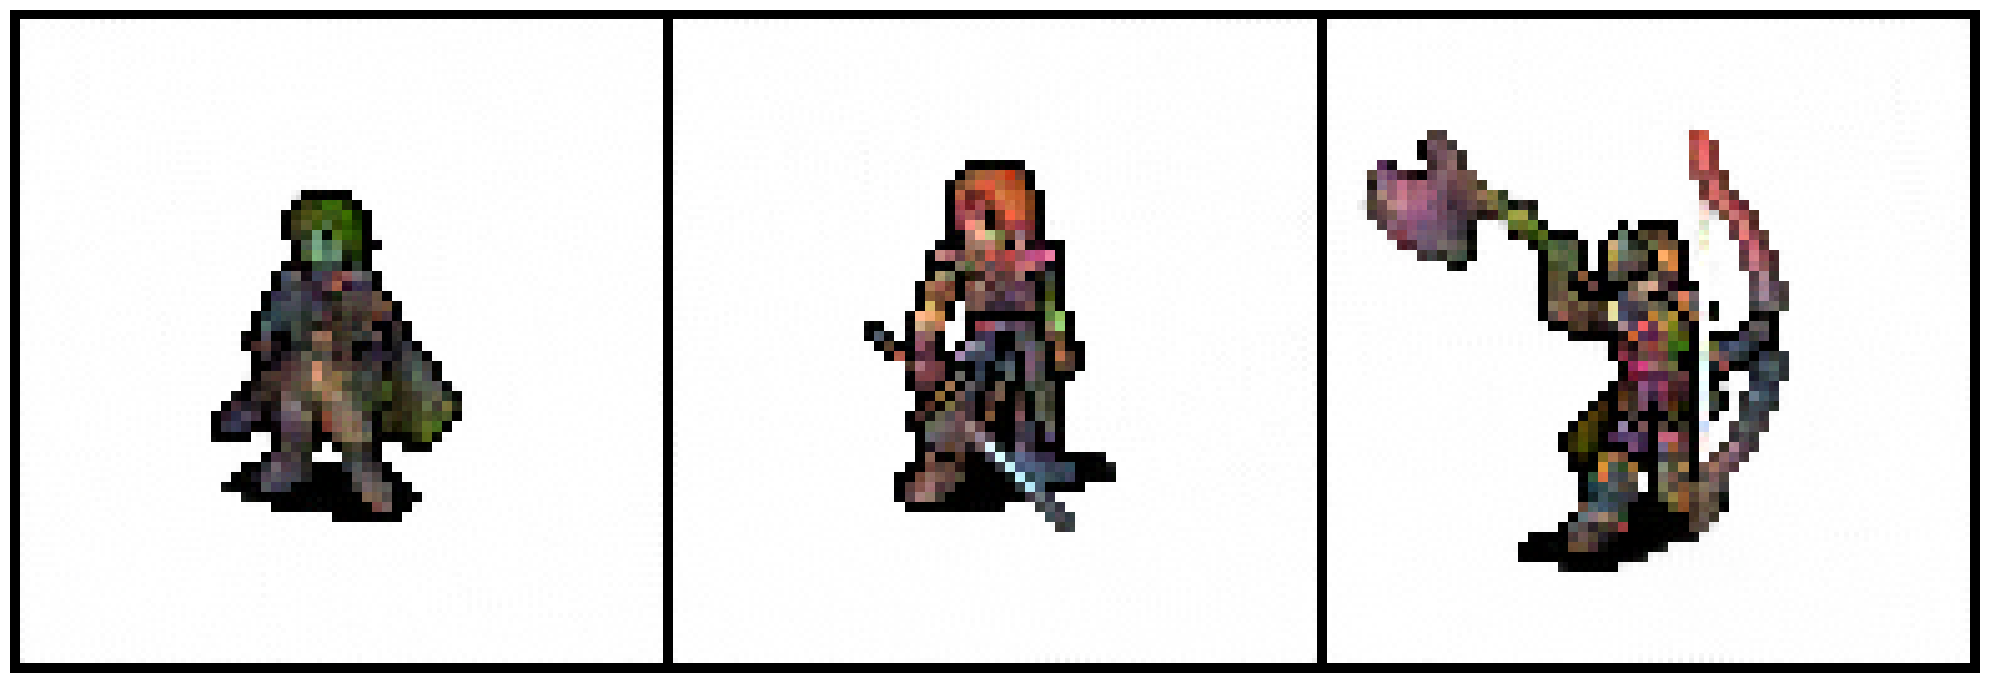

In [34]:
num_samples = 3
num_timesteps = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load model from checkpoint ---
cp = torch.load("training/experiments/unet_mid_ema/best_model.pt", map_location=device)

model = PixelArtUNet(
    channels=[128, 256, 512, 512],
    num_residual_layers=2,
    t_embed_dim=128,
    midcoder_dropout_p=0.2
).to(device)

# Restore EMA weights
ema2 = EMA(model)
ema2.load_state_dict(cp["ema_state"])
ema2.apply_shadow()   # now model has EMA weights
model.eval()

# --- Setup path ---
sampler = PixelArtSampler('dataset/images').to(device)
path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=[4, 128, 128],
    alpha=LinearAlpha(),
    beta=LinearBeta()
).to(device)

# --- Simulate ---
ts = torch.linspace(0, 1, num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
x0 = path.p_simple.sample(num_samples).to(device)  # (num_samples, 4, 128, 128)

ode = UnguidedVectorFieldODE(model)
simulator = EulerSimulator(ode)
x1 = simulator.simulate(x0, ts)  # (num_samples, 4, 128, 128)

# Save individual RGBA outputs
for i in range(num_samples):
    img_tensor = x1[i]
    img = tensor_to_rgba_image(img_tensor)
    img.save(f"assets/unet_mid_ema/image_{i}.png")

# --- Composite for visualization ---
rgba = x1[:, :4]
rgb = rgba[:, :3]
alpha = rgba[:, 3:4]

rgb = (rgb + 1) / 2      # [-1,1] → [0,1]
alpha = (alpha + 1) / 2  # [-1,1] → [0,1]

white_bg = torch.ones_like(rgb)  # white background
img = alpha * rgb + (1 - alpha) * white_bg

# Make grid
grid = make_grid(img, nrow=num_samples, normalize=False)

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(grid.permute(1, 2, 0).clamp(0, 1).cpu().numpy())
plt.axis("off")
plt.tight_layout()
plt.show()